In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from scipy.sparse import coo_matrix, csr_matrix
from matplotlib.pyplot import imshow, colorbar
from numpy.testing import assert_array_equal, assert_allclose, assert_almost_equal

In [2]:
matrix_file='/tmp/matrix.txt'

def read_freefem_coo_matrix(matrix_file, print_shape=False):
    """
    Read from a file an sparse matrix as defined by FreeFem++
    
    Matrix is converted to the coo_matrix format of scipy.sparse
    """
    f = open(matrix_file, "r")
    reading_matrix_data = False
    reading_matrix_header = False
    I=[]
    J=[]
    V=[]
    for l in f.readlines():
        if not reading_matrix_data:
            if l[:7]=='# after': # Next line will contain matrix data
                reading_matrix_data = True
                reading_matrix_header = True
        else:
            if reading_matrix_header:
                # Read matrix header
                nrows, ncols, dummy, nnz = list( map (int, l.split()) )
                if print_shape:
                    print(f"nrows={nrows}, ncols={ncols}, nnz={nnz}")
                reading_matrix_header = False
                matrix_row = 0
            else:
                # Read matrix row, column, value
                lista_ijv = l.split()
                i=int(lista_ijv[0])
                j=int(lista_ijv[1])
                value=float(lista_ijv[2])
                I.append(i)
                J.append(j)
                V.append(value)
                matrix_row = matrix_row + 1
                if matrix_row == nnz:
                    break
    I = I-np.ones_like(I)
    J = J-np.ones_like(J)   
    #   print(f"I={I}")
    #   print(f"J={J}")
    return coo_matrix((V, (I,J)))

def rows_sum(A):
    nrows, ncols = A.shape
    return array([ np.sum(A[i,:]) for i in range(nrows) ])
def cols_sum(A):
    nrows, ncols = A.shape
    return array([ np.sum(A[:,j]) for j in range(nrows) ])

def show_matrix_info(A, print_rows_sum=False, print_cols_sum=False, color_map='CMRmap'):            
    # * Plot matrix
    im=imshow(A, cmap=color_map)
    colorbar(im)
    plt.show()
    
    # * Print rows and columns sum
    if print_rows_sum:
        print("Sum of rows   :", end=" ")
        print(rows_sum(A))
    if print_cols_sum:
        print("Sum of columns:", end=" ")
        print(cols_sum(A))
        
def assert_symmetric(A): 
    "Comprobar que A es antidiagonal (excepción en caso contrario)"
    assert_almost_equal(A, A.transpose() )
    
def assert_antisymmetric(A): 
    "Comprobar que A es antidiagonal (excepción en caso contrario)"
    assert_almost_equal(A, np.diag(2*np.diagonal(A)) - A.transpose() )
    
def assert_diagonal(A):
    "Comprobar que A es diagonal"
    assert_almost_equal(A, np.diag(np.diagonal(A)))

def assert_zero_rows_sum(A):
    "Comprobar que todas las filas de A tienen suma cero"
    rsum = rows_sum(A)
    assert_almost_equal(np.zeros_like(rsum), rsum)
    
def assert_zero_cols_sum(A):
    "Comprobar que todas las columnas de A tienen suma cero"
    csum = cols_sum(A)
    assert_almost_equal(np.zeros_like(csum), csum)

## Mass matrix

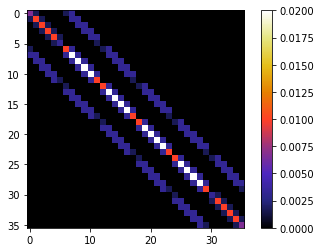

In [3]:
matrix_dir = "./"

M = read_freefem_coo_matrix(matrix_dir + "M.matrix.coo").toarray()
show_matrix_info(M)

assert_symmetric(M)

## Lumped (low order) mass matrix

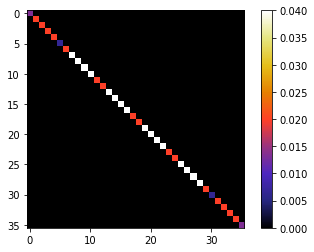

In [4]:
ML = read_freefem_coo_matrix(matrix_dir + "ML.matrix.coo").toarray()
show_matrix_info(ML)

assert_diagonal(ML)
assert_allclose(rows_sum(M), rows_sum(ML))
assert_allclose(cols_sum(M), cols_sum(ML))

## Diffusion matrix, L

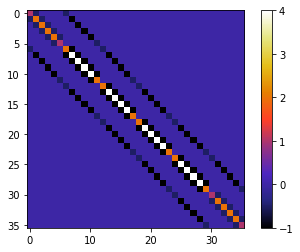

Sum of rows   : [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -1.11022302e-16 -2.22044605e-16  0.00000000e+00 -2.22044605e-16
 -2.22044605e-16 -3.33066907e-16  2.22044605e-16 -4.44089210e-16
 -8.88178420e-16 -2.22044605e-16 -8.88178420e-16 -2.77555756e-16
 -2.22044605e-16 -2.22044605e-16 -4.44089210e-16 -4.44089210e-16
 -4.44089210e-16 -2.77555756e-16  1.11022302e-16 -2.22044605e-16
 -3.33066907e-16  2.77555756e-16 -3.33066907e-16  0.00000000e+00]
Sum of columns: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16
 -1.11022302e-16 -2.22044605e-16  0.00000000e+00 -2.22044605e-16
 -2.22044605e-16 -3.33066907e-16  2.22044605e-16 -4.44089210e-16
 -8.88178420e-16 -2.22044605e-16 -8.88178420e-16 -2.77555

In [5]:
L = read_freefem_coo_matrix(matrix_dir + "L.matrix.coo").toarray()
show_matrix_info(L, print_cols_sum=True, print_rows_sum=True)

assert_symmetric(L) # L es simétrica
assert_zero_cols_sum(L) # Las columnas tienen suma cero
assert_zero_rows_sum(L) # las filas tienen suma cero

## Convection matrix

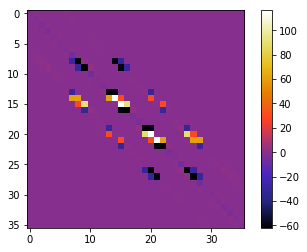

In [6]:
K = read_freefem_coo_matrix(matrix_dir + "K.matrix.coo").toarray()
show_matrix_info(K, color_map='CMRmap')

# Comprobar que las suma por columnas es cero
assert_zero_cols_sum(K)

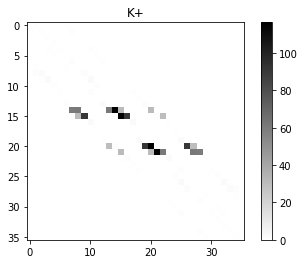

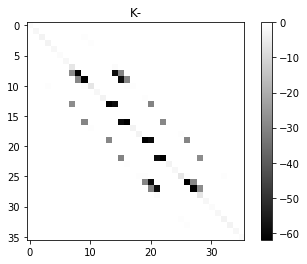

In [7]:
im=imshow(np.where(K>0,K,0), cmap='binary')
colorbar(im)
plt.title("K+")
plt.show()

im=imshow(np.where(K<0,K,0), cmap='gray')
colorbar(im)
plt.title("K-")
plt.show()

## Artificial diffusion matrix, D 

D will be added to convection matrix, K (obtaining KL=K+D), in order to eliminate all negative off-diagonal entries.

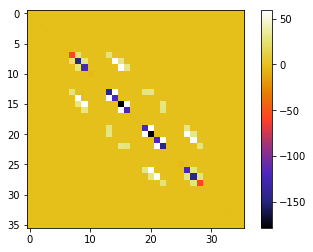


**Property**: "difussion" of D
- Extra-diagonal elements are positive
- Diagonal elements of L are negative, specifically: 
    $a_{ii}=-\sum_{j\neq i} a_{ij}$)


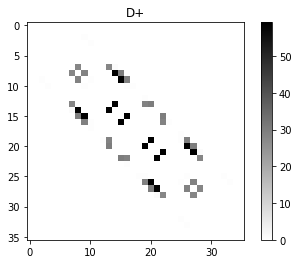

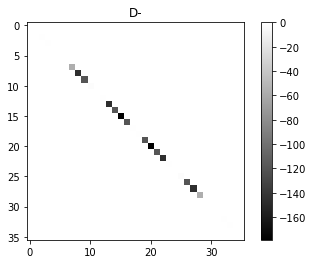

In [8]:
D = read_freefem_coo_matrix(matrix_dir + "D.matrix.coo").toarray()
show_matrix_info(D)
plt.show()

# La matriz es simétrica
assert_symmetric(D)
# La suma de las columnas tiene que ser cero!
assert_zero_cols_sum(D)
# La suma de las filas tiene que ser cero!
assert_zero_rows_sum(D)

print(r"""
**Property**: "difussion" of D
- Extra-diagonal elements are positive
- Diagonal elements of L are negative, specifically: 
    $a_{ii}=-\sum_{j\neq i} a_{ij}$)""")

im=imshow(np.where(D>0,D,0), cmap='binary')
colorbar(im)
plt.title("D+")
plt.show()

im=imshow(np.where(D<0,D,0), cmap='gray')
colorbar(im)
plt.title("D-")
plt.show()

## Corrected diffusion matrix, KL=K+D

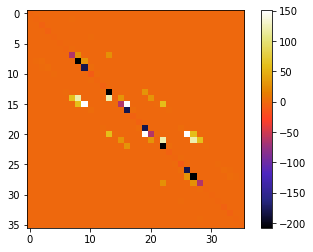

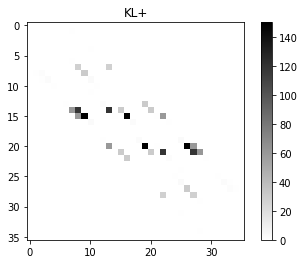

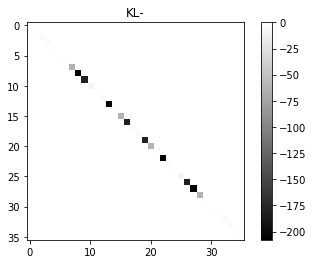

In [9]:
KL = read_freefem_coo_matrix(matrix_dir + "KL.matrix.coo").toarray()

# Error si $KL \neq K+D$:
assert_array_equal(KL, K+D)

# Comprobar que las suma por columnas es cero
assert_zero_cols_sum(KL)

show_matrix_info(KL)

im=imshow(np.where(KL>0,KL,0), cmap='binary')
colorbar(im)
plt.title("KL+")
plt.show()

im=imshow(np.where(KL<0,KL,0), cmap='gray')
colorbar(im)
plt.title("KL-")
plt.show()

## Residual matrix: mass lumping error + artificial diffusion

**Warning:** *Time step*, **dt**, defined here, must match the FreeFem++ program!

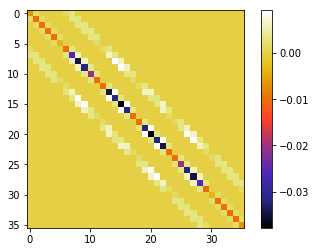

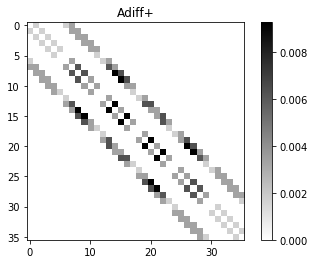

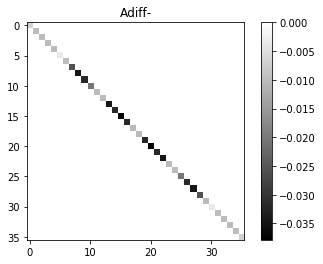

In [10]:
#===========================================================
#-----------------------------------------------------------
dt = 1.e-4; ## WARNING, it must match the FreeFem++ program!
#-----------------------------------------------------------
#===========================================================

Adiff = M - ML + dt*D
assert_symmetric(Adiff)

show_matrix_info(Adiff)

im=imshow(np.where(Adiff>0, Adiff, 0), cmap="binary")
colorbar(im)
plt.title("Adiff+")
plt.show()

im=imshow(np.where(Adiff<0, Adiff, 0), cmap="gray")
colorbar(im)
plt.title("Adiff-")
plt.show()

### Matriz UU de gradientes, $u_j - u_i$

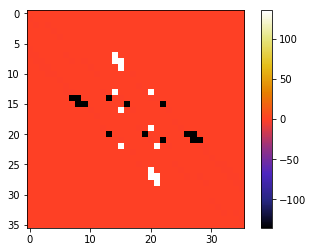

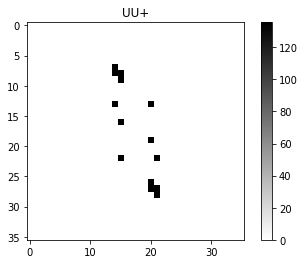

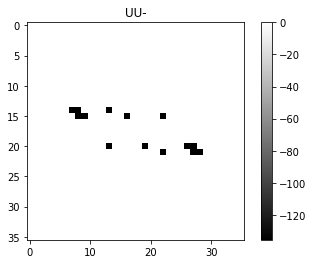

In [11]:
UU = read_freefem_coo_matrix(matrix_dir + "UU.matrix.coo").toarray()
assert_antisymmetric(UU)

show_matrix_info(UU)
plt.show()

im=imshow(np.where(UU>0, UU, 0), cmap="binary")
colorbar(im)
plt.title("UU+")
plt.show()

im=imshow(np.where(UU<0, UU, 0), cmap="gray")
colorbar(im)
plt.title("UU-")
plt.show()

### Flux matrix FF (start of limiting process)

- First, fluxes are defined as sum of diffussion operators (M-ML+D).
- Then, those that are "too difusive" are cancelled ($f_{ij}=0$ if $f_{ij}(u_j-u_i)>0$) 

Previous flux:


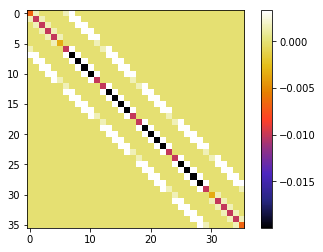

FF_pre*UU matrix ($f_{ij}(u_j-u_i)$):


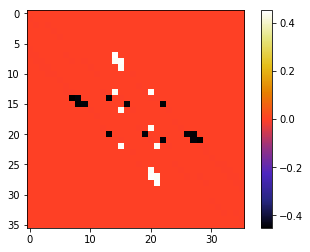

Corrected flux ($f_{ij}=0$ if $f_{ij}(u_j-u_i)>0$):


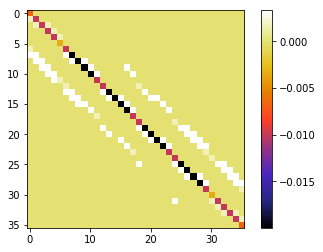

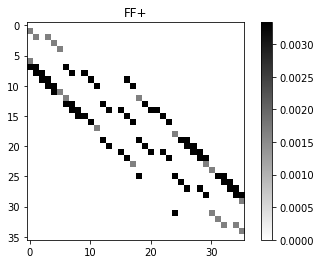

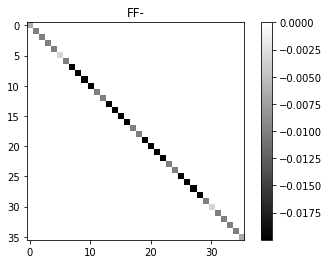

In [13]:
# Read previous fluxes (in order to test everitything is working)
FF_pre = read_freefem_coo_matrix(matrix_dir + "FF_previous.matrix.coo").toarray()

#assert_almost_equal(FF_pre, Adiff*UU)
#assert_antisymmetric(FF_pre)

print("Previous flux:")
show_matrix_info(FF_pre)

print("FF_pre*UU matrix ($f_{ij}(u_j-u_i)$):")
show_matrix_info(FF_pre*UU)

# Read actual fluxes (modified with $f_{ij}=0$ if $f_{ij}(u_j-u_i)>0$)
FF= read_freefem_coo_matrix(matrix_dir + "FF.matrix.coo").toarray()

print("Corrected flux ($f_{ij}=0$ if $f_{ij}(u_j-u_i)>0$):")
show_matrix_info(FF)

im=imshow(np.where(FF>0, FF, 0), cmap="binary")
colorbar(im)
plt.title("FF+")
plt.show()

im=imshow(np.where(FF<0, FF, 0), cmap="gray")
colorbar(im)
plt.title("FF-")
plt.show()

### Matrix $\alpha$ of correction factors

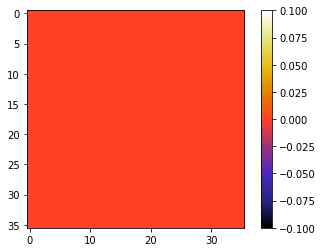

In [14]:
alpha = read_freefem_coo_matrix(matrix_dir + "alpha.matrix.coo").toarray()
show_matrix_info(alpha)